<title>Decoding</title>

In [25]:
from scipy.stats import multivariate_normal
import numpy as np
import math
import gurobipy
%run performance_utils.py

ERROR:root:File `u'performance_utils.py'` not found.


In [7]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Probabilistic Decoding for Intelligent Text Entry

<a href="http://pokristensson.com">Per Ola Kristensson</a>, Department of Engineering, University of Cambridge, UK.

Copyright (c) 2017 Per Ola Kristensson. All rights reserved.

In this tutorial we will explore <em>statistical decoding</em> as a technique for designing intelligent interactive systems.


| Outline                                               | Exercises |
|:------------------------------------------------------|:-|
| Motivation                                            |  |
| Introduction to Statistical Decoding                  |  |
| Statistical Decoding using Token Passing              | Group Discussion, Ex1. Test your understanding |
| _Coffee Break_                                        ||
| Decoding with substitutions, deletions and insertions | Group Discussions, _Ex2. Use log probabilties_ |
| _Lunch_                                               ||
| Statistical Language Modelling                        | Ex3: Improve the statistical decoder |
| _Coffee Break_                                        ||
| Training your own decoder                             | Ex4: Finding good parameters (competitive) |
| Extensions                                            | |


## Introduction

An intelligent text entry method is a text entry method that _infers_ users' intended text. We have known how to design such methods for quite some time. One of the more interesting examples is a 12th century shorthand system called _Nova ars notaria_ ("the new note art") by the monk of John of Tilbury. What is interesting with this system is that the _design principles_ are known:

* Simplify letters to line marks.
* Compress common word stems into sequences of simple line marks and dots.
* Identify common word stems by frequency analysis

In other words, two fundamental principles underpin the design of any efficient text entry method:

* Minimise users' effort in articulating their input.
* Exploit the redundancies in natural languages using statistical language modelling.

However, _how_ can we both minimise users' articulation effort and leverage the redundancies in natural languages? The solution is to perform _statistical decoding_. A statistical decoder is a generative probabilistic model that is capable of searching a vast hypothesis space in order to identify users' intended text given noisy observations.

## Statistical Decoding

The problem we are adressing is a user attempting to communciate information over some form of channel. In Human-Computer Interaction (HCI) we typically model a user transmitting _information_ to a computer system.

The term _information_ in HCI usually refers to characters (for example, typing on a keyboard), words (using speech recognition), or commands (for instance by using keyboard shortcuts or touchscreen gestures).

More formally, we intend to transmit a message $y$ via some form of signal $x$. In a perfect world this would be trivially achieved via a lookup-table. Unfortunately we live in an imperfect world and as a consequence our signal will be perturbed by noise in our neuromuscular system, device sensor imprecision, cognitive errors by the user, etc. Due to this inherent uncertainty it makes sense to model the problem _probabilistically_.

We then wish to compute the probability of the message $y$ _given_ the signal $x$. This can be written mathematically as $P(y | x)$.

<p>
The probability $P(y|x)$ is known as a _conditional probability_ and it is (by either the definition of conditional probability or as an axiom of probability):
</p>

\begin{equation}
P(y|x) = \frac{P(x \cap y)}{P(x)}
\end{equation}

(We are going to assume $P(x)\neq0$ and $P(y)\neq 0$).

The above equation states that the conditional probability of $y$ given $x$ is identical to the ratio of the _joint probability_ of $x$ and $y$ and the probability of $x$. The joint probability of $x$ and $y$ can also be written as $P(x,y)$. 

We can rewrite the conditional probability $P(y|x)$ as follows:

\begin{align}
P(y|x) &= \frac{P(x \cap y)}{P(x)}\\
P(x|y) &= \frac{P(y \cap x)}{P(y)} = \frac{P(x \cap y)}{P(y)}\\
\Rightarrow P(x \cap y) &= P(x|y)P(y) = P(y|x)P(x)\\
\Rightarrow P(y|x) &= \frac{P(x|y)P(y)}{P(x)}\\
\end{align}

This last expression is known as _Bayes' rule_ (or theorem). Usually we have many possible messages that we wish to decode and $P(y|x)$ will then become the _posterior_ probability distribution, assigning a probability to every possible message. Our objective is to compute this posterior probability distribution and select the most probable message.

Now, since we are usually only interested in the most probable message $\hat{y}$ we can write:

\begin{equation}
\hat{y}=\underset{y}{\arg\max}\left[P(y|x)\right]
\end{equation}

We have already seen that the conditional probability $P(y|x)$ can be written using Bayes' rule:

\begin{equation}
\hat{y}=\underset{y}{\arg\max}\left[\frac{P(x|y)P(y)}{P(x)}\right]
\end{equation}

However, as we are only interested in the message that maximises the conditional probability of the message given the signal, the denominator $P(x)$ will be invariant and can therefore be dropped:

\begin{equation}
\hat{y}=\underset{y}{\arg\max}\left[P(x|y)P(y)\right]
\end{equation}

$P(x|y)$ is the likelihood of the signal $x$ given a particular hypothesis for what the message $y$ could be. $P(y)$ is the _prior_ probability of the message, that is, without taking any signal into account. For instance, if a system can only recognise two messages, $x_1$ and $x_2$, and both are equally likely in the absence of any additional information, then the prior probability of either $x_1$ or $x_2$ is $0.5$.

Identifying the highest probable message $y$ is a _search problem_. We search by consulting a model of the likelihood of a signal $x$ given a message $y$ under consideration and by consulting a model of the prior probability of a message $y$ without any consideration to any signal. This search will generate _hypotheses_ and these hypotheses will have probabilities assigned to them. Usually, the hypothesis with the highest probability assigned to it is our preferred hypothesis:

\begin{equation}
\hat{\text{hypothesis}}=\underset{\text{hypotheses}}{\arg\max}\left(\text{likelihood model}\cdot\text{prior model}\right)
\end{equation}

<h2>Sequence Decoding</h2>

Let us assume we have a simple touchscreen keyboard which can generate $k$ distinct letters $L=\left\{l_1, l_2, \ldots, l_k\right\}$.

We view our signal as a discrete <em>observation sequence</em>, which, for ease of notation, we will denote $O$. When a user is typing on the touchscreen keyboard we are provided with a touch point coordinate $(x,y)$, where $x$ and $y$ are the horizontal and vertical components of the touch point respectively. A set of $n$ touch points then form $n$ observations:

\begin{equation}
O = \left\{o^{(1)}, o^{(2)}, \ldots, o^{(n)}\right\}
\end{equation}

Since subscripts are often used to denote specific members of a set, we use a superscript within parantheses to denote the index of an individual observation in an sequence (indexing starts at 1). This means that for instance the sequence $l_1, l_2$ means two letters selected from the set of letters that can be generated by the keyboard (which, since we have defined the keyboard above to generate distinct letters, means $l_1 \neq l_2$). In contrast, $l_1^{(1)},l_1^{(2)}$ means we have generated the _same_ letter $l_1$ twice. Similarly, $l_1^{(1)},l_2^{(2)}$ means we have generated the letter sequence $l_1, l_2$.

We are now given a set of observations $O = \left\{o^{(1)}, o^{(2)}, \ldots, o^{(n)}\right\}$ and we wish to find a _hypothesis_ for $O$, which is a corresponding letter sequence ${L} = \left\{l^{(1)}, l^{(2)}, \ldots, l^{(m)}\right\}$. Note that the cardinality of $O$ and $L$ are not necessarily identical, that is, it is not neccesarily true that $n = m$ ($|O|=|L|$). There are obviously many possible letter sequences that can match the observation sequence. However, we are only interested in the most _probable_ letter sequence $\hat{L}$, and this can be computed using the expression we derived earlier:

\begin{equation}
\hat{L}=\underset{L}{\arg\max}\left[P(O|L)P(L)\right]
\end{equation}

$P(L)$ is the prior. What would be a suitable model for the prior probability of a letter sequence? This particular problem is known as _statistical language modelling_ and it is a research area that has received considerable attention. A very simple model is the unigram probability model, which in this case simply assigns a probability to each individual letter $l_i$. The probabilities assigned over the letters $l_1, l_2, \ldots, l_k$ (remember that our keyboard could generate $k$ distinct letters) then must sum to one and this is our prior probability distribution.

$P(O|L)$ is the likelihood of the observation sequence given a particular letter sequence hypothesis. For a touchscreen keyboard this means that we need a model that assigns a probability to an individual $(x,y)$ touch point given a particular letter key hypothesis, that is $P(o_i|l_i)$. A simple way to achieve this is to centre a two-dimensional Gaussian distribution at each key centre and assume each 2D Gaussian has equal variance and that there is no correlation between the horizontal and vertical axes (that is, the covariance matrix is diagonal). 

<img src="imgs/key_with_2d_gaussian.svg">

To compute our likelihood distribution we need to compute the probability of observing a specific touch point for all possible $k$ letters that can be generated by the keyboard. For example, if our keyboard has two keys, say $A$ and $B$ generating the letters $a$ and $b$ respectively, then our likelihood distribution would need to be computed by computing the probability of the touch point for key $A$ and key $B$. If the touch point is centred at key $A$ the probability will be maximised for $A$ and smaller for $B$ (we assume keys do not overlap spatially).

<img src="imgs/ab_keys_with_2d_gaussian.svg">

<p>
The search for the most probable letter sequence given an observation sequence can be modelled as a (discrete-time) <em>Markov chain</em>. A Markov chain assumes a future state is conditional on the previously known state and independent of any other previous or future states.
</p>

<h2>Statistical Decoding using Token Passing</h2>

<p>
We will now explain how to statistically decode the observation sequence $O$ into the most probable letter sequence $L$. There are several algorithms for learning a hidden Markov model and performing inference. For our particular decoding problem a flexible and efficient method is known as <em>token passing</em>. A particular advantage is that it can efficiently search more complex models and it can be easily parallelised.
</p>

<h3>Token</h3>

<p>
Fundamental to token passing is the notion of a <em>token</em>. A token is a data structure that at a minimum contains the following information: 1) the hypothesis generated so far; and 2) the accumulated probability of the hypothesis. For a touchscreen keyboard the hypothesis generated so far is a letter sequence (a string). For bookkeeping reasons we will also let each token store which observation index it belongs to.
</p>

In [8]:
class Token:
    def __init__(self, hypo, acc_prob, obs_index):
        self.hypo = hypo
        self.acc_prob = acc_prob
        self.obs_index = obs_index

<h3>Observation</h3>

<p>
An observation is simply an $(x,y)$ touch point.
</p>

In [9]:
class Observation:
    def __init__(self, x, y):
        self.x = x
        self.y = y

<h3>Observation Sequence</h3>

<p>
The observation sequence $O = \left\{o^{(1)}, o^{(2)}, \ldots, o^{(n)}\right\}$ is simply a series of observations. They could be kept in a list but it is often convenient to represent them as a separate class when we later improve the model's performance.
</p>

In [10]:
class ObservationSequence:
    def __init__(self, seq):
        self.seq = seq

<h3>Key</h3>

<p>
A key describes the geometry of the keyboard. In this case our likelihood model is very simple. All we need is information on where to centre the 2D Gaussian, which means we need the centre coordinate of the key, and the letter generated by the key. Below we have generated a simple keyboard layout with four keys: A, B, C and D.
</p>

<img src="imgs/key_layout.svg">

In [11]:
class Key:
    def __init__(self, centre_x, centre_y, letter):
        self.centre_x = centre_x
        self.centre_y = centre_y
        self.letter = letter
                
a_key = Key(0.0,0.0,'a')
b_key = Key(0.0,1.0,'b')
c_key = Key(1.0,0.0,'c')
d_key = Key(1.0,1.0,'d')
keys = [a_key, b_key, c_key, d_key]

### Prior

The prior is in this instance the simple unigram probability of the letter. It can be implemented using a simple hash table. To make the demonstration simple we will assume a unigram letter model and all of the letters will be equally probable.

In [12]:
lm = {'a':0.25,'b':0.25,'c':0.25,'d':0.25}
def get_prior(context, lm):
    c = context[-1]
    return lm[c]

### Likelihood

The likelihood is a 2D Gaussian probability density function for the key corresponding to the letter under consideration, evaluated at the coordinate specified by the observation. To make the demonstration simple we will assume a symmetrical 2D Gaussian with unit variance.

In [13]:
def get_likelihood(x, y, key):
    key_x = key.centre_x
    key_y = key.centre_y
    p = multivariate_normal.pdf([x,y], mean=[key_x,key_y], cov=[[1,0],[0,1]]);
    return p

## Substitution-Only Decoder

The first decoder we will look at is a _substitution-only_ decoder. It takes as input:

* A set of $k$ symbols that can be recognised.
* A set of keys (a centre coordinate and a letter, the letter must correspond to a symbol in the symbol set).
* A language model (in this case a simple mapping of a single letter to a probability).
* An observation sequence.

Our decoder will receive a series of touch points, that is $O = \left\{o^{(1)}, o^{(2)}, \ldots, o^{(n)}\right\}$.

To be able to decode such a model we start with a single initial token. The process now works as follows. We take any token at observation index $i \in [0,n)$ and we propagate $k$ tokens to observation index $i+1$. We do this until we are at the last observation and can no longer propagate any tokens. These final tokens represent all hypotheses for the observation sequence. The token with the most probable hypothesis is the most likely letter sequence corresponding to the observation sequence.

The model of the substitution-only decoder is shown below. An initial start state leads to a state each for every observation. States are linked by edges. Each edge links two states and generates a symbol. A series of edges generate a _path_. As is evident in the figure, several paths are possible from the start state to the end state. The subsitution-only decoder below will search _all_ such possible paths and substitute an observation for a symbol every time a particular edge is traversed when transitioning from one state to another.

<img src="imgs/simple_chain.svg">

The code below provides several possible observation sequences. The default observation sequence is empty and generates the expected result that the decoder predicts an empty hypothesis (no letter generated) given an empty observation sequence. By commenting and uncommenting the observation sequences it is possible to explore a few observation sequences:

* No observations. This generates a single-state search space.
* A noisy single touch in the vicinity of the A key. This generates a two-state search space.
* Two noisy touches, both in the vicinity of the A key. This generates a three-state search space.
* Two noisy touches near the B key followed by the A key. This generates a three-state search space.
* Three noisy touches near the B key followed by the A key, followed by the D key. This generates a four-state search space (illustrated in the figure above).

<div class="alert alert-info">
<strong>GROUP DISCUSSION:</strong> 
<ul>
    <li>
        How does the number of tokens relate to the number of observations?
    </li>
    <li>
        Why is the letter sequence probability the same for 'b' and 'c' in the sequence with a single observation?
    </li>
</ul>
</div>

In [14]:
symbols = ['a','b','c','d']
obs_seq = ObservationSequence([]) #No observations
#obs_seq = ObservationSequence([Observation(0.1,0.1)]) #a + noise
#obs_seq = ObservationSequence([Observation(0.1,0.1),Observation(0.15,-0.1)]) #aa + noise
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1)]) #ba + noise
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(1.05,0.95)]) #bad + noise
completed_tokens = []

def get_key_for_symbol(symbol):
    for key in keys:
        if key.letter == symbol:
            return key
    return None

# Convenience function for nicely printing token passing results
def print_sorted_tokens(sorted_tokens):
    results = sorted_tokens
    results = zip(range(1,len(results) + 1), results)
    shortened_id = 15
    shortened = False
    if (len(results) > 32):
        results = results[:shortened_id] + results[-shortened_id:]
        shortened = True
    print("letter sequence")
    print("nth best, hypothesis, probability")
    for i, result in results:
        if (result.acc_prob < 1e-7):
            print("%d, %s, %.3g" % (i, result.hypo, result.acc_prob))
        else:
            print("%d, %s, %.7f" % (i, result.hypo, result.acc_prob))
        if (i == shortened_id and shortened):
            print("...")

def propagate(token, obs_seq, completed_tokens):
    # Which observation is the token in?
    ix = token.obs_index
    # Are there more observations?
    next_ix = ix + 1
    if next_ix == len(obs_seq.seq):
        # No more observations, add token to the list of completed tokens
        completed_tokens.append(token)
    else:
        # There is another observation, propagage a token per symbol to the next observation
        next_obs = obs_seq.seq[next_ix]
        for symbol in symbols:
            # Find the key that generates the symbol
            key = get_key_for_symbol(symbol)
            # Calculate the prior probability of our symbol given previous symbols we have generated
            prior = get_prior(token.hypo+symbol, lm)
            # Calculate the likelihood of the observation (touch coordinate) given our current symbol hypothesis
            likelihood = get_likelihood(next_obs.x, next_obs.y, key)
            # Calculate an accumulated probability for our posterior probability
            acc_prob = token.acc_prob * prior * likelihood
            # Create a new token for the next observation index that contains the accumulated hypothesis and probability
            new_token = Token(token.hypo+symbol, acc_prob, next_ix)
            # Propagate our token
            propagate(new_token, obs_seq, completed_tokens)

# To start the process we need to create an initial token which we can then propagate to the first observation index
seed_token = Token("", 1.0, -1)
# Propagating the first token starts the search process
propagate(seed_token, obs_seq, completed_tokens)
# Sort the list of completed tokens according to the probabilities of their hypotheses
results = sorted(completed_tokens, key=lambda token: token.acc_prob, reverse=True)

# Print out sequence hypotheses and their probabilities
print_sorted_tokens(results)

letter sequence
nth best, hypothesis, probability
1, , 1.0000000


<p>
<div class="alert alert-block alert-success"> 
<h3>Exercise 1</h3> 
<br>
Write a test to independently compute the probabilities of the length 1 and 2 observation sequences examined above by completing the followings stubs.  Ensure you understand what the recursive token propagation method is achieving.
</div>
</p>

<div class="alert alert-block alert-success"> 
<strong>Task 1:</strong> Complete the following stub code to ensure the test passes for the single observation case
</div>

In [15]:
def TestSingleObservation(observation_sequence, sequence_probabilities, tolerance):
    # This flag will stay True if your test passes
    test_passes = True

    # Pull out the single observation
    obs1 = observation_sequence.seq[0]
    
    token_count = 0
    
    # Loop through possible symbols (letter keys)
    for symbol in symbols:
        # Find the key that generates the symbol
        key = get_key_for_symbol(symbol)

        # TODO: Compute the prior, likelihood and accumulated probability after the single observation
        prior = get_prior(symbol, lm)
        likelihood = get_likelihood(obs1.x, obs1.y, key)
        acc_prob = prior * likelihood

        # Compare accumulated probability to that reported from our recursive token passing method
        if not (abs(obs_seq1_prob[token_count] - acc_prob) < tol):
            test_passes = False
        token_count += 1
        
    return test_passes

Run the test to ensure it passes (no code changes required)

In [16]:
# Do not change the tolerance
tol = 0.000001

# A sequence with a single Observation
obs_seq1 = ObservationSequence([Observation(0.1,0.1)]) #a + noise
# The probabilities associated with the four possible token hypotheses, i.e. 'a','b','c','d'
obs_seq1_prob = [0.039393,0.026406,0.026406,0.017700]

if (TestSingleObservation(obs_seq1,obs_seq1_prob,tol)):
    print("PASSED: well done!")
else:
    print("FAILED: try again!")

PASSED: well done!


<div class="alert alert-block alert-success"> 
<strong>Task 2:</strong> Complete the following stub code to ensure the test passes for two observations in the sequence
</div>

In [17]:
def TestTwoObservations(observation_sequence, sequence_probabilities, tolerance):
    # This flag will stay True if your test passes
    test_passes = True

    # Pull out the two observations in the sequence
    obs1 = observation_sequence.seq[0]
    obs2 = observation_sequence.seq[1]

    token_count = 0
    
    # Loop through possible symbols (letter keys) for the first observation
    for symbol_obs1 in symbols:
        # Find the key that generates the symbol
        key1 = get_key_for_symbol(symbol_obs1)

        # TODO compute the prior, likelihood and accumulated probability after the first observation
        obs1_prior = get_prior(symbol_obs1, lm)
        obs1_likelihood = get_likelihood(obs1.x, obs1.y, key1)
        acc_prob_obs1 = obs1_prior * obs1_likelihood

        # Loop through possible symbols (letter keys) for the second observation
        for symbol_obs2 in symbols:
            # Find the key that generates the symbol
            key2 = get_key_for_symbol(symbol_obs2)
            
            # TODO compute the prior, likelihood and accumulated probability after the second observation
            obs2_prior = get_prior(symbol_obs2, lm)
            obs2_likelihood = get_likelihood(obs2.x, obs2.y, key2)
            acc_prob = acc_prob_obs1 * obs1_prior * obs2_likelihood

            # Compare accumulated probability to that reported from our recursive token passing method
            if not (abs(obs_seq2_prob[token_count] - acc_prob) < tol):           
                test_passes = False
            token_count += 1
    return test_passes

Run the test for the case of two observations in a sequence (no code changes required)

In [18]:
# Do not change the tolerance
tol = 0.000001

# A sequence with a two Observations
obs_seq2 = ObservationSequence([Observation(0.1,0.1),Observation(0.15,-0.1)]) #aa + noise
# The probabilities associated with the 16 possible token hypotheses, i.e. 'aa','ab','ac','ad', 'ba', 'bb', ... ,'dd'
obs_seq2_prob = [0.001542,0.000846,0.001087,0.000596,\
                 0.001034,0.000567,0.000728,0.000400,\
                 0.001034,0.000567,0.000728,0.000400,\
                 0.000693,0.000380,0.000488,0.000268,]

if (TestTwoObservations(obs_seq2,obs_seq2_prob,tol)):
    print("PASSED: well done!")
else:
    print("FAILED: try again!")

PASSED: well done!


## Decoding with Substitutions and Deletions

Our first decoder has some limitations. In particular, it cannot identify a hypothesis which contains more symbols than the number of observations. However, we can easily modify the decoder to handle both substitutions and deletions of observations. We do this by modifying our <em>propagate</em> function so that instead of generating $k$ transitions ($k$ tokens), each transition modelling a substituion of an observation with a letter, we generate $k+1$ transitions ($k+1$ tokens). The additional transition (token) models an $\epsilon$-transition (see figure below).

<img src="imgs/simple_epsilon_chain.svg">

Incorporating the $\epsilon$-transition, we can see below that the decoder is able to ignore noisy observations. For instance, for the observation sequence modelling letter keys: B, A, (noise), D, the decoder is able to delete the noisy observation. If we had a more sophisticated language model, the decoder would now be able to correct misspellings and accidental touches on letter keys.

<div class="alert alert-info">
<strong>GROUP DISCUSSION:</strong> 
<ul>
    <li>
        Compare the deletion penalty value used here to the probabilities determined for the single observation sequence examined above?
    </li>
    <li>
        Roughly, at what distance does the spurious third observation in the four observation sequence below start to be interpreted as a legitimate touch for the best hypothesis?
    </li>
</ul>
</div>

In [19]:
symbols = ['a','b','c','d','ɛ'] #Epsilon represents a delete observation event (i.e. do not generate a hypothesis)
obs_seq = ObservationSequence([]) #No observations
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(1.05,0.95)]) #bad + noise
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(3.0,-2.7),Observation(1.05,0.95)]) #b - a - (Noisy input far away from any key) - d + noise
completed_tokens = []
deletion_penalty = 0.02

def get_key_for_symbol(symbol):
    for key in keys:
        if key.letter == symbol:
            return key
    return None

def propagate(token, obs_seq, completed_tokens):
    # Which observation is the token in?
    ix = token.obs_index
    # Are there more observations?
    next_ix = ix + 1
    if next_ix == len(obs_seq.seq):
        # No more observations, add token to the list of completed tokens
        completed_tokens.append(token)
    else:
        # There is another observation, propagage a token per symbol to the next observation
        next_obs = obs_seq.seq[next_ix]
        for symbol in symbols:
            if symbol == 'ɛ':
                # Delete observation
                acc_prob = token.acc_prob * deletion_penalty
                # Create a new token for the next observation index but don't accumulate a hypothesis
                new_token = Token(token.hypo, acc_prob, next_ix)
                propagate(new_token, obs_seq, completed_tokens)
            else:
                # Substitute observation for symbol
                key = get_key_for_symbol(symbol)
                prior = get_prior(token.hypo+symbol, lm)
                likelihood = get_likelihood(next_obs.x, next_obs.y, key)
                acc_prob = token.acc_prob * prior * likelihood
                new_token = Token(token.hypo+symbol, acc_prob, next_ix)
                propagate(new_token, obs_seq, completed_tokens)

seed_token = Token("", 1.0, -1)
propagate(seed_token, obs_seq, completed_tokens)
results = sorted(completed_tokens, key=lambda token: token.acc_prob, reverse=True)

# Print out sequence hypotheses and their probabilities
print_sorted_tokens(results)

letter sequence
nth best, hypothesis, probability
1, , 1.0000000


## Beam Pruning

Our prior decoders will generate exponential growth in the number of tokens as a function of the number of observations. At observation index 1 we have propagated $k$ tokens, at observation index 2 we have propaged $k^2$ tokens, and so on.

To keep the search complexity tractable we observe that many tokens that we are propagated are highly unlikely to contain the most probable hypotheses. These tokens can be filtered out using <em>beam pruning</em>. For every observation index we store the highest accumulated probability we have generated so far for that particular observation. We then impose a condition before we propagate a token: only propagate the token if the token's accumulated probability is within a certain distance to the highest accumulated probability for the next observation. This distance is known as the <em>beam width</em> and it is a parameter that can be used to set the operating point (or trade-off) between accuracy and time when searching for a hypothesis. The narrower the beam the more greedy the search becomes.

We can see that the decoder generates less hypotheses as some hypotheses are eliminated in the search.

<div class="alert alert-info">
<strong>GROUP DISCUSSION:</strong> 
<ul>
    <li>
        Examine how increasing the beam width to around 0.7 affects the resulting hypotheses?
    </li>
    <li>
        What is a potential downside of introducing beam pruning?
    </li>
</ul>
</div>

Sq: 0  beam width: 0.0  time: 0.497181892395
Sq: 1  beam width: 0.05  time: 0.0663568973541
Sq: 2  beam width: 0.1  time: 0.0559060573578
Sq: 3  beam width: 0.15  time: 0.057363986969
Sq: 4  beam width: 0.2  time: 0.0381720066071
Sq: 5  beam width: 0.25  time: 0.0420398712158
Sq: 6  beam width: 0.3  time: 0.0690159797668
Sq: 7  beam width: 0.35  time: 0.0947179794312
Sq: 8  beam width: 0.4  time: 0.0619809627533
Sq: 9  beam width: 0.45  time: 0.0421998500824
Sq: 10  beam width: 0.5  time: 0.0563879013062
Sq: 11  beam width: 0.55  time: 0.0235290527344
Sq: 12  beam width: 0.6  time: 0.0203149318695
Sq: 13  beam width: 0.65  time: 0.0327119827271
Sq: 14  beam width: 0.7  time: 0.00654482841492
Sq: 15  beam width: 0.75  time: 0.00683307647705
Sq: 16  beam width: 0.8  time: 0.0207290649414
Sq: 17  beam width: 0.85  time: 0.0259749889374
Sq: 18  beam width: 0.9  time: 0.0030529499054
Sq: 19  beam width: 0.95  time: 0.0190370082855
Sq: 20  beam width: 1.0  time: 0.0105111598969


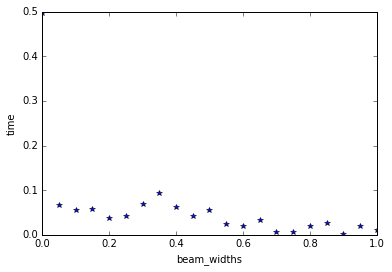

In [20]:
import matplotlib.pyplot as mpl
import time
class ObservationSequence:
    def __init__(self, seq):
        self.seq = seq
        self.beam = [0.0]*len(seq) 

symbols = ['a','b','c','d','ɛ'] #Epsilon represents a delete observation event (i.e. do not generate a hypothesis)
#obs_seq = ObservationSequence([]) #No observations
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(1.05,0.95)]) #bad + noise
obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(3.0,-2.7),Observation(1.05,0.95)]) #b - a - (Noisy input far away from any key) - d + noise
completed_tokens = []
deletion_penalty = 0.02

# Custom
# 
#beam_width = 0.7
beam_widths = [i*0.01 for i in range(0, 105, 5)]
times = []
#
# Custom

def get_key_for_symbol(symbol):
    for key in keys:
        if key.letter == symbol:
            return key
    return None

def beam_prune(p, obs_seq, obs_seq_index):
    bp = obs_seq.beam[obs_seq_index]
    if p > bp:
        obs_seq.beam[obs_seq_index] = p
        return False
    else:
        if p < beam_width * bp:
            return True
        else:
            return False

def propagate(token, obs_seq, completed_tokens):
    ix = token.obs_index
    next_ix = ix + 1
    if next_ix == len(obs_seq.seq):
        completed_tokens.append(token)
    else:
        next_obs = obs_seq.seq[next_ix]
        for symbol in symbols:
            if symbol == 'ɛ':
                acc_prob = token.acc_prob * deletion_penalty
                new_token = Token(token.hypo, acc_prob, next_ix)
                if not beam_prune(acc_prob, obs_seq, next_ix):
                    propagate(new_token, obs_seq, completed_tokens)
            else:
                key = get_key_for_symbol(symbol)
                prior = get_prior(token.hypo+symbol, lm)
                likelihood = get_likelihood(next_obs.x, next_obs.y, key)
                acc_prob = token.acc_prob * prior * likelihood
                new_token = Token(token.hypo+symbol, acc_prob, next_ix)
                if not beam_prune(acc_prob, obs_seq, next_ix):
                    propagate(new_token, obs_seq, completed_tokens)

# Custom
#
for beam_width in beam_widths:
    start = time.time()
    seed_token = Token("", 1.0, -1)
    propagate(seed_token, obs_seq, completed_tokens)
    results = sorted(completed_tokens, key=lambda token: token.acc_prob, reverse=True)
    end = time.time()
    times.append(end-start)
#print(beam_widths)
#print(times)
for i in range(0,len(beam_widths)):
    print "Sq:",i," beam width:",beam_widths[i]," time:",times[i]

plot = mpl.plot(beam_widths, times, '*')
mpl.xlabel("beam_widths")
mpl.ylabel("time")
mpl.show()
#
# Custom

#seed_token = Token("", 1.0, -1)
#propagate(seed_token, obs_seq, completed_tokens)
#results = sorted(completed_tokens, key=lambda token: token.acc_prob, reverse=True)

# Print out sequence hypotheses and their probabilities
#print_sorted_tokens(results)

## Decoding with Substitutions, Deletions and Insertions

Our latest decoder can substitute observations into either letters or empty strings ($\epsilon$-transitions). However, it cannot model the fact that a user may have accidentally failed to touch a letter key. To correct this behaviour we need to model <em>insertion</em> transitions. This can be done by adding <em>self-loops</em> to each state, see the figure below. Each self-loop can generate any symbol.

To model such insertions we modify our <em>propagate</em> function again. Instead of simply propagating $k+1$ tokens to observation index $i+1$, we also propagate $k$ tokens to observation index $i$, the observation index of the token under consideration.

Our search space is no longer increasing exponentially: it is infinite. The reason is that the decoding process can stay at observation index $i$ indefinately and keep generating new tokens. Therefore insertions need to carry an <em>insertion penalty</em>. If the beam width and the insertion penalty are set correctly, the search becomes tractable again.

<img src="imgs/simple_self-loop_chain.svg">

<div class="alert alert-info">
<strong>GROUP DISCUSSION:</strong> 
<ul>
    <li>
        Examine how adjusting the insertion penalty affects the length of the resulting hypotheses (advise not going above ~3)?
    </li>
    <li>
        How does the concept of an insertion penalty loosely relate to the way we have modelled the likelihood of an observation?
    </li>
</ul>
</div>

In [21]:
class ObservationSequence:
    def __init__(self, seq):
        self.seq = seq
        self.beam = [0.0]*len(seq) 

symbols = ['a','b','c','d','ɛ'] #Epsilon represents a delete observation event (i.e. do not generate a hypothesis)
obs_seq = ObservationSequence([]) #No observations
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(1.05,0.95)]) #bad + noise
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(3.0,-2.7),Observation(1.05,0.95)]) #b - a - (Noisy input far away from any key) - d + noise
completed_tokens = []
deletion_penalty = 0.02
insertion_penalty = 1.2
beam_width = 0.2

def get_key_for_symbol(symbol):
    for key in keys:
        if key.letter == symbol:
            return key
    return None

def beam_prune(p, obs_seq, obs_seq_index):
    bp = obs_seq.beam[obs_seq_index]
    if p > bp:
        obs_seq.beam[obs_seq_index] = p
        return False
    else:
        if p < beam_width * bp:
            return True
        else:
            return False

def propagate(token, obs_seq, completed_tokens):
    # Which observation is the token in?
    ix = token.obs_index
    # Are there more observations?
    next_ix = ix + 1
    if next_ix == len(obs_seq.seq):
        # No more observations, add token to the list of completed tokens
        completed_tokens.append(token)
    else:
        # There is another observation, propagage tokens for all symbols to the next observation index
        next_obs = obs_seq.seq[next_ix]
        for symbol in symbols:
            if symbol == 'ɛ':
                acc_prob = token.acc_prob * deletion_penalty
                new_token = Token(token.hypo, acc_prob, next_ix)
                if not beam_prune(acc_prob, obs_seq, next_ix):
                    propagate(new_token, obs_seq, completed_tokens)
            else:
                key = get_key_for_symbol(symbol)
                prior = get_prior(token.hypo+symbol, lm)
                likelihood = get_likelihood(next_obs.x, next_obs.y, key)
                acc_prob = token.acc_prob * prior * likelihood
                new_token = Token(token.hypo+symbol, acc_prob, next_ix)
                if not beam_prune(acc_prob, obs_seq, next_ix):
                    propagate(new_token, obs_seq, completed_tokens)
    # Propagate tokens for all symbols (except epsilon) within the same observation index
    if ix >= 0:
        for symbol in symbols:
            if not symbol == 'ɛ':
                key = get_key_for_symbol(symbol)
                prior = get_prior(token.hypo+symbol, lm)
                obs = obs_seq.seq[ix]
                acc_prob = token.acc_prob * prior * insertion_penalty
                # Create a new token but don't increment the observation index
                new_token = Token(token.hypo+symbol, acc_prob, ix)
                if not beam_prune(acc_prob, obs_seq, ix):
                    propagate(new_token, obs_seq, completed_tokens)

seed_token = Token("", 1.0, -1)
propagate(seed_token, obs_seq, completed_tokens)
results = sorted(completed_tokens, key=lambda token: token.acc_prob, reverse=True)

# Print out sequence hypotheses and their probabilities
print_sorted_tokens(results)

letter sequence
nth best, hypothesis, probability
1, , 1.0000000


We can see from the output that our new decoder is capable of generating longer hypotheses than there are observations. However, the most likely hypothesis remains the same as before. The reason is our parameter settings and our language model. Since our language model simply distributes the probability mass evenly over our four possible letters and does not model probabilities over letter sequences, there is no structure that allows the decoder to sophisticatedly decide to insert a letter. For insertions to be used effectively, a high-quality language model is required.

## Log probabilities

The previous code works but will not scale very well due to numerical underflow. To avoid this, statistical decoding is usually working with probabilities on a logarithmic scale (_log-probs_).

To transform a probability $P$ to the logarithmic scale we compute the natural logarithm, $\ln(P)$. To transform a log-prob back into a regular probability we compute $\exp(\ln(P))$. Adding log-probs has the same effect as multiplying regular probabilties.

An example: 

Let $P_1 = P_2 = 0.5$. 

Then $\ln(P_1) = \ln(P_2) \approx -0.693$. 

$\ln(P_1) + \ln(P_2) \approx -1.386$ and $\exp\left[\ln(P_1) + \ln(P_2)\right] = 0.25$.

In [22]:
P1 = 0.5
P2 = 0.5

joint_P1_P2 = P1 * P2

# Take log
log_P1 = math.log(P1)
log_P2 = math.log(P2)

# Sum log probs
log_joint_P1_P2 = log_P1 + log_P2

# Take exp(log(P))
e_log_joint_P1_P2 = math.exp(log_joint_P1_P2)

print('Multiplied Probabilities - Summed Log Probabilities')
print('%.3g - %.3g' % (joint_P1_P2,e_log_joint_P1_P2))

Multiplied Probabilities - Summed Log Probabilities
0.25 - 0.25


<p>
<div class="alert alert-block alert-success"> 
<h3>Exercise 2: Use Log Probabilities</h3> 
<br>
Work in your group and extend the decoder to use log probabilities throughout. Check that the results returned are the same as those above.
</div>
</p>

In [23]:
class ObservationSequence:
    def __init__(self, seq):
        self.seq = seq
        self.beam = [0.0]*len(seq) 

symbols = ['a','b','c','d','ɛ'] #Epsilon represents a delete observation event (i.e. do not generate a hypothesis)
obs_seq = ObservationSequence([]) #No observations
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(1.05,0.95)]) #bad + noise
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(3.0,-2.7),Observation(1.05,0.95)]) #b - a - (Noisy input far away from any key) - d + noise
completed_tokens = []
deletion_penalty = 0.02
insertion_penalty = 1.2
beam_width = 0.2

def get_key_for_symbol(symbol):
    for key in keys:
        if key.letter == symbol:
            return key
    return None

def beam_prune(p, obs_seq, obs_seq_index):
    bp = obs_seq.beam[obs_seq_index]
    if p > bp:
        obs_seq.beam[obs_seq_index] = p
        return False
    else:
        if p < beam_width * bp:
            return True
        else:
            return False

def propagate(token, obs_seq, completed_tokens):
    # Which observation is the token in?
    ix = token.obs_index
    # Are there more observations?
    next_ix = ix + 1
    if next_ix == len(obs_seq.seq):
        # No more observations, add token to the list of completed tokens
        completed_tokens.append(token)
    else:
        # There is another observation, propagage tokens for all symbols to the next observation index
        next_obs = obs_seq.seq[next_ix]
        for symbol in symbols:
            if symbol == 'ɛ':
                acc_prob = token.acc_prob * deletion_penalty
                new_token = Token(token.hypo, acc_prob, next_ix)
                if not beam_prune(acc_prob, obs_seq, next_ix):
                    propagate(new_token, obs_seq, completed_tokens)
            else:
                key = get_key_for_symbol(symbol)
                prior = get_prior(token.hypo+symbol, lm)
                likelihood = get_likelihood(next_obs.x, next_obs.y, key)
                acc_prob = token.acc_prob * prior * likelihood
                new_token = Token(token.hypo+symbol, acc_prob, next_ix)
                if not beam_prune(acc_prob, obs_seq, next_ix):
                    propagate(new_token, obs_seq, completed_tokens)
    # Propagate tokens for all symbols (except epsilon) within the same observation index
    if ix >= 0:
        for symbol in symbols:
            if not symbol == 'ɛ':
                key = get_key_for_symbol(symbol)
                prior = get_prior(token.hypo+symbol, lm)
                obs = obs_seq.seq[ix]
                acc_prob = token.acc_prob * prior * insertion_penalty
                # Create a new token but don't increment the observation index
                new_token = Token(token.hypo+symbol, acc_prob, ix)
                if not beam_prune(acc_prob, obs_seq, ix):
                    propagate(new_token, obs_seq, completed_tokens)

seed_token = Token("", 1.0, -1)
propagate(seed_token, obs_seq, completed_tokens)
results = sorted(completed_tokens, key=lambda token: token.acc_prob, reverse=True)

# Print out sequence hypotheses and their probabilities
print_sorted_tokens(results)

letter sequence
nth best, hypothesis, probability
1, , 1.0000000


# Statistical Language Modelling

A _statistical language model_ is a model that assigns probabilities to sequences of letters or words.

### Information, Entropy and Perplexity

To understand how to model languages we need to understand what a _message_ is and how we can quantify the information in a message. A message $m$ in some message space $M$ is sent from a _sender_ to a _receiver_. Importantly, for a message $m$ to carry information $I(m)$ from the sender to the recevier the information must not already be known to the receiver. If the information is already known $I(m)=0$. $I(m)$ measures the amount of new information, or _surprisal_, there is in receiving a message. The more surprising the message is to the receiver, the more information content in the message.

$I(m)$ is called _self-information_ and is defined as:

\begin{equation}
I(m) = \log_2\left(\frac{1}{P(m)}\right)=-\log_2\left(P\left(m\right)\right),
\end{equation}

where $P(m)$ is the probability of the message in the message space $M$.

The above equation is better understood by considering a message as communicating an event (such as the outcome of flipping a fair coin: heads or tails). Let information about one event $m_1$ be $I(m_1)$ and another event $m_2$ be $I(m_2)$.

Then, _assuming these events are independent_, the information about _both_ these events would be $I_{both} = I(m_1\cap m_2)= I(m_1) + I(m_2)$.

If we now think about the _probabilities_ of these events we have $P(m_1)$ and $P(m_2)$ and $P_{both} = P(m_1\cap m_2)= P(m_1) \cdot P(m_2)$.

In other words, self-information of independent events _adds_ while the probabilities of the events _multiply_. This is exactly how log-probs operate, which explains the logarithm in the above equation. Since logarithms scale with a constant factor we can set this constant factor to be negative in order to ensure information is a positive quantity. The base of the logarithm determines the unit. By convention the base is usually 2 ($\log_2)$ and thus the unit is in _bits_.

<h4>Example 1:</h4>

Consider a Bernoulli trial involving flipping a fair coin. The probability of either outcome is $0.5$. To communicate the specific outcome of an individual event to the sender is the equivalent of sending a message $m$ with $I(m) = \log_2\left(\frac{1}{0.5}\right) =  \log_2(2) = 1$ bit.

<h4>Example 2:</h4>

Consider we wish to communicate the outcome of having flipped a fair coin four times as either $m_a$ (four heads in a row) or $\bar{m_a}$ (_not_ observing four heads in a row). The probability $P(m_a)$ of observing four heads in a row is $\frac{1}{16}$ and $I(m_a) = -\log_2\left(P\left(m_a\right)\right) = -\log_2\left(\frac{1}{16}\right) = 4$ bits. Communicating the other possible outcome, $\bar{m_a}$, we first find the probability $P(\bar{m_a}) = 1 - P(m_a) = 1 - \frac{1}{16} = \frac{15}{16}$. Then $I(\bar{m_a}) = -\log_2\left(\frac{15}{16}\right) \approx 0.093$ bits.

Entropy $H$ is a measure of the _uncertainty_ in the message space $M$.

\begin{equation}
H(M) = \sum_{m \in M} P(m)I(m)=-\sum_{m \in M}P(m)\log_2\left(P(m)\right)
\end{equation}

Entropy is the _average_ self-information of all messages in the message space. Entropy measures disorder. An entropy of zero means there is no disorder and everything is completely predictable.

Entropy tells us the average bits we need to communicate a message, assuming we have found an optimal coding scheme. The difference between the average bits actually used for communication and the optimal bits truly necessary to encode all messages is a measure of _redundancy_. Natural langauges have high redundancy.

A measure related to entropy is _perplexity_, which measures how well a probability model is at prediction. Perplexity is defined as $2^H$, where $H$ is the entropy of the model.

<h4>Example from Jurafsky and Martin 2000; _Speech and Language Processing_:</h4>

We want to bet on eight horses via a middleman. How do we communicate the horse we want to bet on?. One way is to encode this message using binary representation for each horse, horse 1 becomes 001, horse 2 becomes 010, etc. If we spend the whole day betting and each horse is coded with 3 bits then on average we are sending 3 bits per race.

Can we do better? Assume each horse is not equally likely but instead distributed like this: horse 1: $\frac{1}{2}$; horse 2: $\frac{1}{4}$; horse 3: $\frac{1}{8}$; horse 4: $\frac{1}{16}$; and horses 5--8: $\frac{1}{64}$. Then the entropy of the random variable $X$ that ranges over horses gives us a lower bound on the number of bits: $H(X) = -\sum^8_{i=1}P(i)\log_2\left(P(i)\right)=2$ bits. Such a code can be built by using shorter encoding for more probable horses and longer encodings for less probable horses (for example, the most likely horse can be encoded as 0 while the least likely horse can be coded as 111111. If the horses have equal probability then if we repeat the above calculation we will find that the entropy would be 3.

Perplexity is the weighted average number of choices a random variable has to make. Choosing between 8 equally likely horses ($H = 3$ bits) has a perplexity of $2^3 = 8$. Choosing between the biased horses above ($H = 2$ bits) has a perplexity of $2^2 = 4$.






### Modelling language

Since natural languages are highly redundant it follows that the vast majority of letter and word combinations are highly improbable. We can capture probable sequences of letters and words by counting their occurance in some large representative dataset, a _corpus_. A _language model_ assigns probabilities to sequences of letters and words.

We will demonstrate these ideas by using an example from: Shannon, C.E. 1948. A mathematical theory of communication. _Bell System Technical Journal_ 27: 379–423, 623–656.

Consider a discrete source with five letters \{A,B,C,D,E\}. Chosen with probability of 0.2 (uniformaly sampled) and each choice independent of previous choices we might expect a typical outcome such as: B D C B C E C C C A D C B D D A A E C E E A A B B D A E E C A C E E B A E E C B C E A D

We can build a generative model that generates increasingly English-like language output, as follows:

<b>Zero-order approximation (uniform random sampling from {A-Z}:</b>

<em>XFOML RXKHRJFFJUJ ZLPWCFWKCYJ FFJEYVKCQSGHYD QPAAMKBZAACIBZLHJQD</em>

<b>First-order approximation (sampling according to the probabilities of English letters occurring in common texts):</b>

<em>OCRO HLI RGWR NMIELWIS EU LL NBNESEBYA TH EEI ALHENHTTPA OOBTTVA NAH BRL</em>

<b>Second-order approximation (sampling so that the every letter is dependent on its previous letter according to letter probabilities in English):</b>

<em>ON IE ANTSOUTINYS ARE T INCTORE ST BE S DEAMY ACHIN D ILONASIVE TUCOOWE AT TEASONARE FUSO TIZIN ANDY TOBE SEACE CTISBE</em>

<b>Third-order approximation (sampling similar to second-order approximation, except each letter is now dependent on two previous letters):</b>

<em>IN NO IST LAT WHEY CRATICT FROURE BIRS GROCID PONDENOME OF DEMONSTURES OF THE REPTAGIN IS REGOACTIONA OF CRE</em>

<h4>Zipf's law</h4>

Another striking example of language redudandancy is Zipf's law, which estimates the probability $P_r$ of occurrence of a word in a corpus to be $P_r \propto \frac{1}{r^\alpha}$, where $r$ is the statistical rank of the word in decreasing order and $\alpha$ is close to unity. As an example of this relationship, the 100 most frequently used words in the British National Corpus comprise close to 46% of the entire corpus.

<h4><em>n</em>-gram models</h4>

A _unigram model_ assumes any word will follow any other word at an equal probability. The simplest unigram model possible believes every word is equally probable. So if a language consists of $1000$ words then the probability of occurrence of a word is exactly $\frac{1}{1000}$.

The word "the" occurs 69,971 times in the Brown corpus while the word "rabbit" only occurs 11 times. However, what is the most reasonable choice of word to complete the following sentence fragment: "Just then, the white...". Clearly a unigram model makes too simplistic assumptions about natural languages.

We can handle the case with the white rabbit by probabilistically modelling every single possible word combination that can occur in the world. However, it is clearly intractable to model such a large space, which is countably infinite. Therefore, language models make a _Markov assumption_: the probability of a word only depends on a finite set of previous words.

A bigram model approximates the probability of a word given previous words by the conditional probability of a single preceding word. So instead of computing this probability: $P(\text{rabbit}|\text{Just the other day I saw a})$, a bigram model computes the following approximate probability: $P(\text{rabbit}|\text{a})$.

A trigram model is a minor extension to a bigram model: it has two words of prior context. In general, an $n$-gram model has $n-1$ words of context an is said to be of order $n-1$.

The basic way of training a language model is by counting instances of $n$-grams in corpora (frequency estimation). These counts have to be normalised in order to create a probabilistic model. Fundamentally, one takes the count of say a particular bigram and divide it by the sum of all the bigrams that share the first word (which is identical to the unigram count of the first word). This is a form of _parameter estimation_. In general, we estimate an $n$-gram probability by dividing the observed frequency of a particular sequence by the observed frequency of a prefix. Using such relative frequency to estimate probabilities is an example of maximum likelihood estimation (the likelihood of the training set given the model is maximised). Typically language models use log-probs.

The typical way to evaluate a language model is to train it on a training set and test it on a separate test set. The lower the perplexity the better the language model is in predicting text on the test set.

### Smoothing

Our previous language modelling cannot account for $n$-grams we have not previously observed in our training data. Fundamentally, the problem is that our language model is overestimating the probabilities of observed sequences and underestimting unobserved sequences by assigning them zero probability mass. The solution is to distribute some of the probability mass in the language model to unobserved sequences.

The simplest method is to add one to every count of every $n$-gram in the model (this is known as the Laplace method):

\begin{equation}
c^*=c+1,
\end{equation}

where $c$ is the original count and $c^*$ is the modified count. It does solve the problem of zero counts but in practice it results in poor language modelling performance.

A slightly more sophisticated version is known as Good-Turing discounting and it is defined as:

\begin{equation}
c^*=(c+1)\frac{N_{c+1}}{N_c},
\end{equation}

where $c$ is the original count and $c^*$ is the modified count as before and $N_c$ and $N_{c+1}$ are the number of $n$-grams that occur exactly $c$ and $c+1$ times. An obvious problem is when $N_c = 0$. One solution is to plot $\log(c)$ against $\log(Z_c)$, where $Z_c$ is:

\begin{equation}
Z_c = \frac{2N_c}{c''-c'},
\end{equation}

where $c''$ and $c'$ are the nearest higher and lower sample counts such that $N_{c''}$ and $N_{c'}$ are positive. A linear fit between $\log(c)$ against $\log(Z_c)$ can then be obtained by ordinary least squares (OLS) regression and used to infer $N_c$ that are unobservable.

See <a href="https://www.grsampson.net/AGtf.html">Good–Turing Frequency Estimation Without Tears</a> for a complete explanation.

<p>
<div class="alert alert-block alert-success"> 
<h3>Exercise 3: Improve the Statistical Decoder</h3> 
<br>
The code for the statistical decoder you were provided with has a few limitations. In this exercise you will work in your group and introduce a better language model.  Change the uniform unigram model to a character-level language model that learns probabilities for sequences of characters based on a training text and uses smoothing to estimate the probabilities for unseen character sequences.
</div>
</p>

<div class="alert alert-block alert-success"> 
    <strong>Task 1:</strong> Construct a character-level bigram language model based on the provided training text. It is useful to represent the start of a word as a psuedo character.  
</div>

In [24]:
# Load the training text
f_training_text = open('training_text.txt', 'r')
training_text = f_training_text .read()
f_training_text.close()

# Initalize a structure to count character-to-character transitions, include a start-of-word one-way transition denoted '_'
transition_counts = np.matlib.zeros((5,4))
from_ids = {'_':0,'a':1,'b':2,'c':3,'d':4}
to_ids = {'a':0,'b':1,'c':2,'d':3}

# Split the training text into words
training_words = training_text.split(' ')

# Count character transitions
for word in training_words:
    prev_character = '_'
    for character in word:
        # TODO: Update the transition_counts matrix, make use of from_ids and to_ids
        
        # Update previous character
        prev_character = character

# TODO: Apply smoothing (if necessary) and convert the transition counts into a useful bigram


IOError: [Errno 2] No such file or directory: 'training_text.txt'

<div class="alert alert-block alert-success"> 
    <strong>Task 2:</strong> Modify the get_prior method to use use the computed bigram.  
</div>

In [ ]:
# Populate the bigram with computed probabilities
bigram_lm = {'_a':0.05,'_b':0.05,'_c':0.05,'_d':0.05,\
      'aa':0.05,'ab':0.05,'ac':0.05,'ad':0.05,\
      'ba':0.05,'bb':0.05,'bc':0.05,'bd':0.05,\
      'ca':0.05,'cb':0.05,'cc':0.05,'cd':0.05,\
      'da':0.05,'db':0.05,'dc':0.05,'dd':0.05}

# Modify get_prior to return prior for specified context
def get_prior(context, bigram_lm):
    c = context[-1]
    return lm[c]

# When you are happy that your new get_prior is functioning properly, replace the default unigram lm
# lm = bigram_lm

<div class="alert alert-block alert-success"> 
    <strong>Task 3:</strong> Examine the effect of the new language model on decoder performance. Hint: you may want to adjust the deletion penalty.  
</div>

In [ ]:
#obs_seq = ObservationSequence([]) #No observations
obs_seq = ObservationSequence([Observation(0.1,1.1)])
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(1.05,0.95)]) #bad + noise
#obs_seq = ObservationSequence([Observation(0.1,1.1),Observation(0.15,-0.1),Observation(3.0,-2.7),Observation(1.05,0.95)]) #b - a - (Noisy input far away from any key) - d + noise

completed_tokens = []
deletion_penalty = 0.02
insertion_penalty = 1.2
beam_width = 0.2

def propagate(token, obs_seq, completed_tokens):
    # Which observation is the token in?
    ix = token.obs_index
    # Are there more observations?
    next_ix = ix + 1
    if next_ix == len(obs_seq.seq):
        # No more observations, add token to the list of completed tokens
        completed_tokens.append(token)
    else:
        # There is another observation, propagage tokens for all symbols to the next observation index
        next_obs = obs_seq.seq[next_ix]
        for symbol in symbols:
            if symbol == 'ɛ':
                acc_prob = token.acc_prob * deletion_penalty
                new_token = Token(token.hypo, acc_prob, next_ix)
                if not beam_prune(acc_prob, obs_seq, next_ix):
                    propagate(new_token, obs_seq, completed_tokens)
            else:
                key = get_key_for_symbol(symbol)
                prior = get_prior(token.hypo+symbol, lm)
                likelihood = get_likelihood(next_obs.x, next_obs.y, key)
                acc_prob = token.acc_prob * prior * likelihood
                new_token = Token(token.hypo+symbol, acc_prob, next_ix)
                if not beam_prune(acc_prob, obs_seq, next_ix):
                    propagate(new_token, obs_seq, completed_tokens)
    # Propagate tokens for all symbols (except epsilon) within the same observation index
    if ix >= 0:
        for symbol in symbols:
            if not symbol == 'ɛ':
                key = get_key_for_symbol(symbol)
                prior = get_prior(token.hypo+symbol, lm)
                obs = obs_seq.seq[ix]
                acc_prob = token.acc_prob * prior * insertion_penalty
                # Create a new token but don't increment the observation index
                new_token = Token(token.hypo+symbol, acc_prob, ix)
                if not beam_prune(acc_prob, obs_seq, ix):
                    propagate(new_token, obs_seq, completed_tokens)

seed_token = Token("", 1.0, -1)
propagate(seed_token, obs_seq, completed_tokens)
results = sorted(completed_tokens, key=lambda token: token.acc_prob, reverse=True)

# Print out sequence hypotheses and their probabilities
print_sorted_tokens(results)

## Learning Parameters: Grid Search

Once we have designed a probabilistic model for our problem and implemented a token-passing decoder to infer hypotheses from observations, we need to set the parameters. There are many ways to learn parameters. The simplest method is _grid search_, which fixes all parameters except one and then searches for the optimal parameter value under the fixed constraints. The process can be iterated.

A more advanced method is to use the expectation-maximisation (EM) algorithm to learn the parameter set. This is indeed the foundation of the Baum-Welch algorithm for hidden Markov models.

### Metric

To perform grid search, we need a suitable metric to optimise.  A useful metric for comparing the desired letter sequence to the letter sequence actually reproduced is the character error rate (CER).  Here we define character error rate as the number of changes required to transform the received letter sequence (response) into the desired letter sequence (stimulus) divided by the length of the desired letter sequence.

The Levenshtein distance is the number of single-character edits (can be any of: insertion, deletion or substitution) required to transform string A into string B.  The Levenshtein distance provides the numerator when computing character error rate. An example is included below.

When performing grid search we thus want to minimise the average character error rate across the test set.

In [ ]:
stimulus = 'coffee'
response = 'covfefe'

print('stimulus: %s, has %d characters' % (stimulus,len(stimulus)))

ld = levenshtein(stimulus,response)

print('%d single-character edits are required to transform %s into %s' % (ld,response,stimulus))

cer = character_error_rate(stimulus,response)

print('CER is %.2f' % (cer))

<div class="alert alert-block alert-success"> 
<h3>Exercise 4: Learn Parameters from User Data</h3> 
    
Collect sample data and implement grid search to train your statistical decoder.
</div>

<div class="alert alert-block alert-success"> 
    <strong>Task 1:</strong> Use the ABCD toy keyboard below and generate sample data. The toy keyboard will present a set of 10 stimulus words randomly choosen from a larger stimulus set.  Clicking next on the 10th stimulus word will close the keyboard and write a complete stimulus-response log to file.  You can repeat this task as many times as you want but the log file will overwrite. 

</div>

In [ ]:
from toy_keyboard import ToyKeyboard

ToyKeyboard()
%gui tk

<div class="alert alert-block alert-success"> 
    <strong>Task 2:</strong> Implement grid search to find parameter values that minimise character error rates across the sample data you collected. You can explore the effect of modifying any of the parameters you think might be relevant.  You may want to manually inspect reasonable bounds for parameter values before starting the grid search. Code to parse and extract the stimulus-response log is provided below. You should be able to reduce CER to 0. 
</div>

In [ ]:
from parse_sr_log import ParseStimulusResponseLog

# Extract a matched array of stimuli and observation sequences from the stimulus-response.log
stimulus_set, observation_sequence_set = ParseStimulusResponseLog('stimulus_response.log')

# Default parameter values
deletion_penalty = 0.02
insertion_penalty = 1.2
beam_width = 0.2
sigma = 1.0

def get_likelihood(x, y, key):
    key_x = key.centre_x
    key_y = key.centre_y
    p = multivariate_normal.pdf([x,y], mean=[key_x,key_y], cov=[[sigma,0],[0,sigma]]);
    return p

# Keep track of the character error rates
cer_set = []

# Print out stimuli and observation sequences
stimulus_count = 0
for observation_sequence in observation_sequence_set:
    stimulus = stimulus_set[stimulus_count]
    
    # Print out observation points for stimulus
    print("Sequence for: " + stimulus)
    for observation in observation_sequence.seq:
        print('%.3f, %.3f' % (observation.x, observation.y))
    stimulus_count += 1
    
    completed_tokens = []
    
    seed_token = Token("", 1.0, -1)
    propagate(seed_token, observation_sequence, completed_tokens)
    results = sorted(completed_tokens, key=lambda token: token.acc_prob, reverse=True)

    # Get best hypothesis from the decoder result list
    best_response = results[0].hypo
    
    # Compute character error rate
    cer = character_error_rate(stimulus,best_response)
    cer_set.append(cer)
    
    print('S-R: %s-%s' % (stimulus,best_response))
    print('CER: %.2f\n' % (cer))
    
print('Mean CER across training set: %.2f' % (np.mean(cer_set)))

# TODO: implement grid search to minimize CER across your traing data


<div class="alert alert-block alert-success"> 
    <strong>Task 3:</strong> Use a noisy toy keyboard and generate sample data. Perform grid search again. Examine what noise level you can accomodate by adjusting sigma.
</div>

In [ ]:
from noisy_toy_keyboard import NoisyToyKeyboard

NoisyToyKeyboard(sigma=25)
%gui tk

In [ ]:
from parse_sr_log import ParseStimulusResponseLog

# Extract a matched array of stimuli and observation sequences from the stimulus-response.log
stimulus_set, observation_sequence_set = ParseStimulusResponseLog('stimulus_noisy_response.log')

# Default parameter values
deletion_penalty = 0.02
insertion_penalty = 1.2
beam_width = 0.2
sigma = 1.0

def get_likelihood(x, y, key):
    key_x = key.centre_x
    key_y = key.centre_y
    p = multivariate_normal.pdf([x,y], mean=[key_x,key_y], cov=[[sigma,0],[0,sigma]]);
    return p

# Keep track of the character error rates
cer_set = []

# Print out stimuli and observation sequences
stimulus_count = 0
for observation_sequence in observation_sequence_set:
    stimulus = stimulus_set[stimulus_count]
    
    # Print out observation points for stimulus
    print("Sequence for: " + stimulus)
    for observation in observation_sequence.seq:
        print('%.3f, %.3f' % (observation.x, observation.y))
    stimulus_count += 1
    
    completed_tokens = []
    
    seed_token = Token("", 1.0, -1)
    propagate(seed_token, observation_sequence, completed_tokens)
    results = sorted(completed_tokens, key=lambda token: token.acc_prob, reverse=True)

    # Get best hypothesis from the decoder result list
    best_response = results[0].hypo
    
    # Compute character error rate
    cer = character_error_rate(stimulus,best_response)
    cer_set.append(cer)
    
    print('S-R: %s-%s' % (stimulus,best_response))
    print('CER: %.2f\n' % (cer))
    
print('Mean CER across training set: %.2f' % (np.mean(cer_set)))

# TODO: implement grid search to minimize CER


<div class="alert alert-block alert-success"> 
    <strong>Task 4:</strong> Evaluate your refined decoder on the test data generated with the same noisy toy keyboard (sigma=25). You will be judged based on your mean CER across the set of observation sequences. The file (test_data.log) will be committed to the repository at the end of the allocated time.  Ensure all your parameter values are configured as desired before executing. Do not modify the following code.
</div>

In [ ]:
from parse_sr_log import ParseStimulusResponseLog

# Extract a matched array of stimuli and observation sequences from the stimulus-response.log
stimulus_set, observation_sequence_set = ParseStimulusResponseLog('test_data.log')

# Default parameter values
deletion_penalty = 0.02
insertion_penalty = 1.2
beam_width = 0.2
sigma = 1.0

def get_likelihood(x, y, key):
    key_x = key.centre_x
    key_y = key.centre_y
    p = multivariate_normal.pdf([x,y], mean=[key_x,key_y], cov=[[sigma,0],[0,sigma]]);
    return p

# Keep track of the character error rates
cer_set = []

# Print out stimuli and observation sequences
stimulus_count = 0
for observation_sequence in observation_sequence_set:
    stimulus = stimulus_set[stimulus_count]
    stimulus_count += 1
    
    completed_tokens = []
    
    seed_token = Token("", 1.0, -1)
    propagate(seed_token, observation_sequence, completed_tokens)
    results = sorted(completed_tokens, key=lambda token: token.acc_prob, reverse=True)

    # Get best hypothesis from the decoder result list
    best_response = results[0].hypo
    
    # Compute character error rate
    cer = character_error_rate(stimulus,best_response)
    cer_set.append(cer)
    
    print('S-R: %s-%s' % (stimulus,best_response))
    print('CER: %.2f\n' % (cer))
    
print('Mean CER across training set: %.4f' % (np.mean(cer_set)))

## Extensions

Several extensions are possible to gradually augment the above models. Some of these are explained below.

### Adaptive language modelling

We previously developed an $n$-gram model to use as a model for our prior beliefs in the hypotheses we generate during the search. Our $n$-gram model was trained on general text. However, not all users are interested in typing the same text. This observation leads to the idea of _adaptation_. An adaptive language model learns sequences of letters (or words) that the user prefers to type. How to best adapt to users' typing is a challenging and ongoing area of research.

One of the simplest ways is to train a _background_ model and a _foreground_ model. The background model is trained on a large corpus and the foreground model is trained online on text actually typed by the user (by updating the counts in the language model online). Since background models tend to be large it would take a very long time for the users' updated counts to be reflected in the prior. A faster way is to use a mixture model where the log-prob estimates for the background and foreground models are linearly combined with a mixture weight $\alpha$:

\begin{equation}
\ln\left(P_{mixture}\right)=\alpha\ln\left(P_{background}\right)+(1-\alpha)\ln\left(P_{foreground}\right)
\end{equation}

### Confusion networks

Our current decoder only searches for the highest probable hypothesis. However, it is possible to generate a hypothesis space. One useful representation of such a hypotheiss space is a _confusion network_. A confusion network is a set of hypotheses and corresponding posterior probabilities for each observation index. The posterior probabilities are normalized so that they sum to unity. Each observation index has a corresponding _confusion cluster_. A series of confusion clusters form the confusion network.

It is relatively easy to change the decoder code to generate confusion networks. These confusion networks can then be outputted from the decoder and used to for example offer the user a selection of next-best choices if the most probable hypothesis was the uninteded one.

### Parallelisation

Token passing lends itself to parallelisation as we propagate new tokens and mostly read from an immutable observation sequence. This means tokens can be propagated in multiple cores with minimal synchronisation. The beam width is however updated during a search and needs to either be an atomic read/write operation, have a mutual exclusion lock, or be separate for each core.